In [ ]:
# !git clone https://github.com/facebookresearch/detr.git   #cloning github repo of detr to import its unique loss

Cloning into 'detr'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 243 (delta 0), reused 0 (delta 0), pack-reused 239
Receiving objects: 100% (243/243), 12.84 MiB | 3.52 MiB/s, done.
Resolving deltas: 100% (125/125), done.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %set_env PYTHONPATH=/content/drive/My Drive/detr/detr:/env/python

In [ ]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "All libraries are successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-ozd5mcc9
All libraries are successfully installed!


In [2]:
 ! pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 17.5MB/s 
     |████████████████████████████████| 952kB 25.5MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65165 sha256=b912dec799ae4bf05f3483277d1eec58b955680f74f5e8db4e1456918b6d9cf1
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [3]:
# for appending path to os dir- sys.path.append('/content/drive/My Drive/detr/detr/')

import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
# print(sys.path)
sys.path.append('/content/drive/My Drive/detr_new/detr/')
print(sys.path)

from models.matcher import HungarianMatcher
from models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

#Glob
from glob import glob

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/detr_new/detr/']


In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        
    @property
    def avg(self):
        return (self.sum / self.count) if self.count>0 else 0

In [5]:
import configparser
config = configparser.ConfigParser()

In [6]:
config.read("/content/drive/My Drive/detr_new/conf/config.ini")

['/content/drive/My Drive/detr_new/conf/config.ini']

In [7]:
lr_dict = {'backbone':0.1,'transformer':1,'embed':1,'final': 5}

In [8]:
n_folds = int(config['conf_lr_5e-5']['n_folds'])
seed = int(config['conf_lr_5e-5']['seed'])
null_class_coef = float(config['conf_lr_5e-5']['null_class_coef'])
num_classes = int(config['conf_lr_5e-5']['num_classes'])
num_queries = int(config['conf_lr_5e-5']['num_queries'])
BATCH_SIZE = int(config['conf_lr_5e-5']['BATCH_SIZE'])
LR = float(config['conf_lr_5e-5']['LR'])
EPOCHS = int(config['conf_lr_5e-5']['EPOCHS'])
max_norm = int(config['conf_lr_5e-5']['max_norm'])
model_name = config['conf_lr_5e-5']['model_name']

In [9]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [10]:
seed_everything(seed)

In [11]:
marking = pd.read_csv('/content/drive/My Drive/detr_new/hat_data/train.csv')

In [12]:
bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))

for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i] 
    
marking.drop(columns=['bbox'], inplace=True)
# print(marking)


In [13]:
image_data = marking.groupby('image_id')
# print(image_data.groups)
# print(image_data.get_group('004973_jpg.rf.cf4605f7882329f38cebaa44c26618af.jpg'))

In [14]:
images = list(map(lambda x: x.split('.jpg')[0], os.listdir('/content/drive/My Drive/detr_new/hat_data/train/')))
# print(images)

In [15]:

images = list(map(lambda x: x.split('.jpg')[0], os.listdir('/content/drive/My Drive/detr_new/hat_data/train/')))

def get_data(img_id):
    img_id = img_id + ".jpg"
    if img_id not in image_data.groups:
        return dict(image_id=img_id, source='', boxes=list())
    
    data  = image_data.get_group(img_id)
    source = np.unique(data.source.values)
    # assert len(source)==1, 'corrupted data: %s image_id has many sources: %s' %(img_id,source)
    source=data.source.values[0]
    boxes = data[['x','y','w','h']].values
    return dict(image_id = img_id, source=source, boxes = boxes)

image_list = [get_data(img_id) for img_id in images]
# print(image_list)

In [16]:
print(f'total number of images: {len(image_list)}, images with bboxes: {len(image_data)}')
null_images=[x['image_id'] for x in image_list if len(x['boxes'])==0]
len(null_images)

total number of images: 5282, images with bboxes: 5269


13

In [17]:
def add_fold_index(lst,n_folds):
    lens = [len(x['boxes']) for x in lst]
    lens_unique = np.unique(lens)
    i = np.random.randint(n_folds)
    fold_indexes = [[] for _ in range(n_folds)]
    idx = []
    
    for _l in lens_unique:
        idx.extend(np.nonzero(lens==_l)[0].tolist())
        if len(idx)<n_folds: continue
        random.shuffle(idx)
        while len(idx)>= n_folds:
            fold_indexes[i].append(lst[idx.pop()]['image_id'])
            i = (i+1) % n_folds
    while len(idx):
        fold_indexes[i].append(lst[idx.pop()]['image_id'])
        i = (i+1) % n_folds
    
    return fold_indexes
    
sources = np.unique([x['source'] for x in image_list])
splitted_image_list = {s:sorted([x for x in image_list if x['source']==s],key=lambda x: len(x['boxes'])) 
                       for s in sources}
splitted_image_list = {k: add_fold_index(v,n_folds=n_folds) for k,v in splitted_image_list.items()}

fold_indexes = [[] for _ in range(n_folds)]
for k,v in splitted_image_list.items():
    for i in range(n_folds):
        fold_indexes[i].extend(v[i])  
    
print([len(v) for v in fold_indexes])

[1057, 1055, 1056, 1056, 1058]


In [18]:
if False:
    plt.figure(figsize=(10,10))
    for i,img in enumerate(null_images):
        plt.subplot(7,7,i+1)
        plt.imshow(plt.imread(f'../input/hat_data/train/{img}.jpg'))
        plt.axis('off')
        plt.axis('tight')
        plt.axis('equal')

    plt.show()

In [19]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf(
            [
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),      
                A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)
            ],
            p=0.9),         
            #A.ToGray(p=0.01),         
            A.HorizontalFlip(p=0.5),         
            A.VerticalFlip(p=0.5),         
            A.Resize(height=512, width=512, p=1),      
            A.Normalize(max_pixel_value=1),
            #A.Cutout(num_holes=8, max_h_size=32, max_w_size=32, fill_value=0, p=0.5),
            ToTensorV2(p=1.0)
        ], 
        p=1.0,         
        bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
        )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=1.0),
                      A.Normalize(max_pixel_value=1),
                      ToTensorV2(p=1.0),
                      ], 
                      p=1.0, 
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

In [20]:
DIR_TRAIN = '/content/drive/My Drive/detr_new/hat_data/train/'
from skimage import io
class HatDataset(Dataset):
    def __init__(self,image_list,transforms=None):
        self.images = image_list
        self.transforms = transforms
        # print(images)
        self.img_ids = {x['image_id']:i for i,x in enumerate(image_list)}
        
    def get_indices(self,img_ids):
        return [self.img_ids[x] for x in img_ids]
        
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self,index):
        record = self.images[index]
        image_id = record['image_id']
        # print(image_id)

        image = cv2.imread(f'{DIR_TRAIN}/{image_id}', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        
        # DETR takes in data in coco format 
        boxes = record['boxes'] 
        
        labels =  np.zeros(len(boxes), dtype=np.int32)

        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image  = sample['image']
            boxes  = sample['bboxes']
            labels = sample['labels']

        _,h,w = image.shape
        boxes = A.augmentations.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        ## detr uses center_x,center_y,width,height !!
        if len(boxes)>0:
            boxes = np.array(boxes)
            boxes[:,2:] /= 2
            boxes[:,:2] += boxes[:,2:]
        else:
            boxes = np.zeros((0,4))
        # print("+++++++++++.....", boxes)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        
        return image, target, image_id

In [21]:
train_ds = HatDataset(image_list,get_train_transforms())
valid_ds = HatDataset(image_list,get_valid_transforms())

In [22]:
def show_example(image,target,image_id=None):
    np_image = image.cpu().numpy().transpose((1,2,0))
    # unnormalize the image
    np_image = np_image*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    #np_image = (np_image*255).astype(np.uint8)
    target = {k: v.cpu().numpy() for k, v in target.items()} 
    
    boxes = target['boxes']
    # print(boxes)
    h,w,_ = np_image.shape
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
        
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        
        cv2.rectangle(np_image,
                  (box[0]-box[2], box[1]-box[3]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)
        
    ax.set_axis_off()
    ax.imshow(np_image)
    ax.set_title(image_id)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


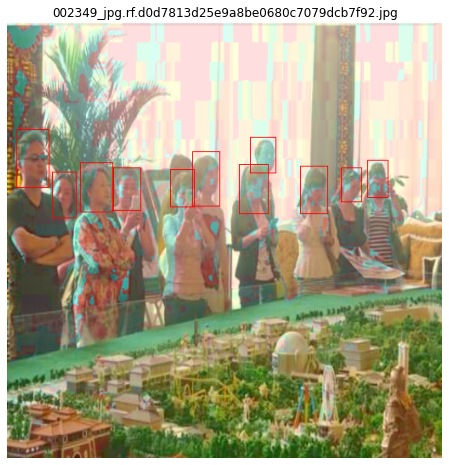

In [23]:
show_example(*train_ds[2])

In [24]:
def DETRModel(num_classes,model_name=model_name):
    model = torch.hub.load('facebookresearch/detr', model_name, pretrained=False, num_classes=num_classes)
    def parameter_groups(self):
        return { 'backbone': [p for n,p in self.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
                 'transformer': [p for n,p in self.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
                 'embed': [p for n,p in self.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad]}
    setattr(type(model),'parameter_groups',parameter_groups)
    return model

class DETRModel(nn.Module):
    def __init__(self,num_classes=1):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        
        self.model = torch.hub.load('facebookresearch/detr', model_name, pretrained=True)
        
        self.out = nn.Linear(in_features=self.model.class_embed.out_features,out_features=num_classes+1)
        
    def forward(self,images):
        d = self.model(images)
        d['pred_logits'] = self.out(d['pred_logits'])
        return d
    
    def parameter_groups(self):
        return { 
            'backbone': [p for n,p in self.model.named_parameters()
                              if ('backbone' in n) and p.requires_grad],
            'transformer': [p for n,p in self.model.named_parameters() 
                                 if (('transformer' in n) or ('input_proj' in n)) and p.requires_grad],
            'embed': [p for n,p in self.model.named_parameters()
                                 if (('class_embed' in n) or ('bbox_embed' in n) or ('query_embed' in n)) 
                           and p.requires_grad],
            'final': self.out.parameters()
            }

In [25]:
model = DETRModel()
model.parameter_groups().keys()

Downloading: "https://github.com/facebookresearch/detr/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


dict_keys(['backbone', 'transformer', 'embed', 'final'])

In [26]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher(cost_giou=2,cost_class=1,cost_bbox=5)

weight_dict = {'loss_ce': 1, 'loss_bbox': 5 , 'loss_giou': 2}

losses = ['labels', 'boxes', 'cardinality']

In [27]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [28]:
def get_fold(fold):
    
    train_indexes = train_ds.get_indices([x for i,f in enumerate(fold_indexes) if i!=fold for x in f])
    valid_indexes = valid_ds.get_indices(fold_indexes[fold])
    
    train_data_loader = DataLoader(
        torch.utils.data.Subset(train_ds,train_indexes),
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        torch.utils.data.Subset(valid_ds,valid_indexes),
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn
    )
    return train_data_loader,valid_data_loader

In [29]:
train_loader,valid_loader = get_fold(0)

In [30]:
valid_iter = iter(valid_loader)
batch  = next(valid_iter)

In [31]:
images,targets,image_id = batch
torch.cat([v['boxes'] for v in targets])

tensor([[0.8430, 0.8253, 0.0210, 0.0280],
        [0.6060, 0.4963, 0.0660, 0.0630],
        [0.3330, 0.5725, 0.0230, 0.0363],
        [0.8650, 0.3767, 0.0890, 0.1463],
        [0.1530, 0.1992, 0.0990, 0.1802],
        [0.4370, 0.3303, 0.0370, 0.0541]])

In [32]:
import util.box_ops  as box_ops

def challenge_metric(outputs,targets):
    logits = outputs['pred_logits']
    boxes  = outputs['pred_boxes']
    return sum(avg_precision(logit[:,0]-logit[:,1],box,target['boxes'])
            for logit,box,target in zip(logits,boxes,targets))/len(logits)

    return {target['image_id']:avg_precision(logit[:,0]-logit[:,1],box,target['boxes'])
            for logit,box,target in zip(logits,boxes,targets)}


@torch.no_grad()
def avg_precision(logit,pboxes,tboxes,reduce=True):
    idx = logit.gt(0)
    if sum(idx)==0 and len(tboxes)==0: 
        return 1 if reduce else [1]*6
    if sum(idx)>0 and len(tboxes)==0: 
        return 0 if reduce else [0]*6
    
    pboxes = pboxes[idx]
    logit = logit[idx]
    
    idx = logit.argsort(descending=True)
    pboxes=box_ops.box_cxcywh_to_xyxy(pboxes.detach()[idx])
    tboxes=box_ops.box_cxcywh_to_xyxy(tboxes)
    
    iou = box_ops.box_iou(pboxes,tboxes)[0].cpu().numpy()
    prec = [precision(iou,th) for th in [0.5,0.55,0.6,0.65,0.7,0.75]]
    if reduce:
        return sum(prec)/6
    return prec
    

def precision(iou,th):
    #if iou.shape==(0,0): return 1

    #if min(*iou.shape)==0: return 0
    tp = 0
    iou = iou.copy()
    num_pred,num_gt = iou.shape
    for i in range(num_pred):
        _iou = iou[i]
        n_hits = (_iou>th).sum()
        if n_hits>0:
            tp += 1
            j = np.argmax(_iou)
            iou[:,j] = 0
    return tp/(num_pred+num_gt-tp)
    

In [34]:
def gen_box(n,scale=1):
    par = torch.randn((n,4)).mul(scale).sigmoid() 
    max_hw = 2*torch.min(par[:,:2],1-par[:,:2])
    par[:,2:] = par[:,2:].min(max_hw)
    return par

pboxes = gen_box(15)
logit = torch.randn(15)
tboxes = gen_box(3) 
#iou = 
avg_precision(logit,pboxes,tboxes)
# iou.gt(0.5),iou,pboxes,tboxes

0.027777777777777776

In [35]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()
    
    tk0 = tqdm(data_loader, total=len(data_loader),leave=False)
    log = None
    
    for step, (images, targets, image_ids) in enumerate(tk0):
        
        batch_size = len(images)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        

        output = model(images)
        
        loss_dict = criterion(output, targets)
        
        if log is None:
            log = {k:AverageMeter() for k in loss_dict}
            log['total_loss'] = AverageMeter()
            log['avg_prec'] = AverageMeter()
            
        weight_dict = criterion.weight_dict
        
        total_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        total_loss.backward()
        
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()
        
        log['total_loss'].update(total_loss.item(),batch_size)
        
        for k,v in loss_dict.items():
            log[k].update(v.item(),batch_size)
            
        log['avg_prec'].update(challenge_metric(output,targets),batch_size)
            
        tk0.set_postfix({k:v.avg for k,v in log.items()}) 
        
    return log

In [36]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    log = None
    
    with torch.no_grad():
        
        tk0 = tqdm(data_loader, total=len(data_loader),leave=False)
        for step, (images, targets, image_ids) in enumerate(tk0):
            
            batch_size = len(images)
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            if log is None:
                log = {k:AverageMeter() for k in loss_dict}
                log['total_loss'] = AverageMeter()
                log['avg_prec'] = AverageMeter()
            
            for k,v in loss_dict.items():
                log[k].update(v.item(),batch_size)
        
            total_loss = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            log['total_loss'].update(total_loss.item(),batch_size)
            log['avg_prec'].update(challenge_metric(output,targets),batch_size)
            
            tk0.set_postfix({k:v.avg for k,v in log.items()}) 
    
    return log #['total_loss']

In [37]:
import json

class Logger:
    def __init__(self,filename,format='csv'):
        self.filename = filename + '.' + format
        self._log = []
        self.format = format
    def save(self,log,epoch=None):
        log['epoch'] = epoch+1
        self._log.append(log)
        if self.format == 'json':
            with open(self.filename,'w') as f:
                json.dump(self._log,f)
        else:
            pd.DataFrame(self._log).to_csv(self.filename,index=False)
            
            
def run(fold,epochs=EPOCHS):
    
    train_data_loader,valid_data_loader = get_fold(fold)
    
    logger = Logger(f'log_{fold}')
    device = torch.device('cuda')
    model = DETRModel(num_classes=num_classes)
    model = model.to(device)
    criterion = SetCriterion(num_classes, 
                             matcher, weight_dict, 
                             eos_coef = null_class_coef, 
                             losses=losses)
    
    criterion = criterion.to(device)
    

    optimizer = torch.optim.AdamW([{
        'params': v,
        'lr': lr_dict.get(k,1)*LR
    } for k,v in model.parameter_groups().items()], weight_decay=1e-4)
    
    best_precision = 0
    header_printed = False
    for epoch in range(epochs):
        train_log = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
        valid_log = eval_fn(valid_data_loader, model,criterion, device)
    
        log = {k:v.avg for k,v in train_log.items()}
        log.update({'V/'+k:v.avg for k,v in valid_log.items()})
        logger.save(log,epoch)
        keys = sorted(log.keys())
        
        if not header_printed:
            print(' '.join(map(lambda k: f'{k[:8]:8}',keys)))
            header_printed = True
        print(' '.join(map(lambda k: f'{log[k]:8.3f}'[:8],keys)))
        
        if log['V/avg_prec'] > best_precision:
            best_precision = log['V/avg_prec']
            print('Best model found at epoch {}'.format(epoch+1))
            torch.save(model.state_dict(), f'detr_bst_{fold}.pth')
        

In [38]:
import gc
gc.collect()

2277

In [39]:
# LR = 5e-5 batch_size = 6

In [39]:
run(fold=0,epochs=20)

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


V/avg_pr V/cardin V/class_ V/loss_b V/loss_c V/loss_g V/total_ avg_prec cardinal class_er epoch    loss_bbo loss_ce  loss_gio total_lo
   0.171    2.126   71.380    0.029    0.158    0.344    0.990    0.087    2.959   84.096    1.000    0.043    0.199    0.490    1.391
Best model found at epoch 1


   0.351    1.380   37.720    0.028    0.117    0.350    0.959    0.212    1.754   52.676    2.000    0.035    0.146    0.465    1.250
Best model found at epoch 2


   0.455    1.045   25.752    0.026    0.095    0.340    0.906    0.305    1.428   41.188    3.000    0.031    0.126    0.438    1.156
Best model found at epoch 3


   0.471    0.992   18.248    0.026    0.082    0.337    0.887    0.349    1.258   33.345    4.000    0.032    0.109    0.442    1.152
Best model found at epoch 4


   0.413    1.025   24.367    0.026    0.094    0.354    0.934    0.368    1.236   32.884    5.000    0.031    0.106    0.436    1.131


   0.473    0.956   18.441    0.026    0.081    0.341    0.894    0.378    1.182   34.355    6.000    0.029    0.109    0.432    1.121
Best model found at epoch 6


   0.457    1.006   13.546    0.026    0.073    0.352    0.908    0.392    1.148   31.065    7.000    0.029    0.100    0.434    1.116


   0.507    0.898   17.648    0.025    0.079    0.338    0.880    0.407    1.230   33.557    8.000    0.029    0.108    0.419    1.089
Best model found at epoch 8


   0.522    0.844   15.826    0.024    0.071    0.327    0.843    0.430    1.071   30.348    9.000    0.027    0.100    0.412    1.062
Best model found at epoch 9


   0.527    0.887   15.040    0.024    0.072    0.325    0.842    0.423    1.047   28.606   10.000    0.029    0.094    0.431    1.101
Best model found at epoch 10


   0.549    0.802   15.207    0.024    0.071    0.320    0.829    0.433    1.074   29.277   11.000    0.028    0.096    0.415    1.065
Best model found at epoch 11


   0.530    0.764   14.382    0.024    0.068    0.326    0.839    0.465    0.999   27.655   12.000    0.026    0.092    0.395    1.015


   0.454    0.867   14.161    0.028    0.064    0.373    0.948    0.423    1.078   28.895   13.000    0.031    0.095    0.435    1.118


   0.567    0.803   16.948    0.023    0.068    0.309    0.802    0.425    1.066   27.213   14.000    0.029    0.091    0.428    1.090
Best model found at epoch 14


   0.488    0.852   12.794    0.025    0.067    0.346    0.880    0.441    1.076   28.790   15.000    0.027    0.094    0.404    1.036


   0.516    0.817   13.226    0.024    0.066    0.332    0.849    0.446    1.085   28.643   16.000    0.027    0.093    0.405    1.036


   0.551    0.875   14.742    0.024    0.071    0.309    0.808    0.463    1.079   28.916   17.000    0.026    0.094    0.391    1.005


   0.541    0.798   12.067    0.022    0.065    0.315    0.808    0.482    0.990   25.644   18.000    0.025    0.085    0.389    0.990


   0.577    0.860   12.832    0.023    0.070    0.300    0.784    0.486    0.987   26.404   19.000    0.025    0.089    0.384    0.985
Best model found at epoch 19


   0.519    0.821   12.104    0.027    0.065    0.346    0.891    0.457    1.074   28.255   20.000    0.030    0.092    0.425    1.090


In [40]:
 def show_predictions(images,outputs,targets):
    _,h,w = images[0].shape
    
    boxes = targets[0]['boxes'].cpu().numpy() #.astype(np.int32)
    boxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(boxes,h,w)]
    np_image = images[0].permute(1,2,0).cpu().numpy()
    np_image = np_image*np.array([0.229, 0.224, 0.225])+np.array([0.485, 0.456, 0.406])
    
    #outputs = [{k: v.cpu() for k, v in output.items()}]
    
    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(np_image,
                  (box[0]-box[2], box[1]-box[3]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 2)
    
    oboxes = outputs['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.augmentations.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    prob   = outputs['pred_logits'][0].softmax(1).detach().cpu().numpy()[:,0]
    for box,p in zip(oboxes,prob):
        if p>0.1:
            color = (0,0,220)
            # color = (0,0,220) if p>0.5 else (0,220,0)
            cv2.rectangle(np_image,
                      (box[0]-box[2], box[1]-box[3]),
                      (box[2]+box[0], box[3]+box[1]),
                      color, 1)
            # cv2.putText(np_image, "wh" , (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (209, 80, 0, 255), 1)
    
    ax.set_axis_off()
    ax.imshow(np_image)
    #return images,outputs,targets

In [41]:
model = DETRModel()
model.load_state_dict(torch.load("./detr_bst_0.pth"))
model.to(torch.device('cuda'))

Using cache found in /root/.cache/torch/hub/facebookresearch_detr_master


DETRModel(
  (model): DETR(
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
            )
            (linear1): Linear(in_features=256, out_features=2048, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
            (linear2): Linear(in_features=2048, out_features=256, bias=True)
            (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.1, inplace=False)
            (dropout2): Dropout(p=0.1, inplace=False)
          )
          (1): TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): _LinearWithBias(in_features=256, out_features=256, bias=True)
            )
            (linear1):

In [42]:
train_loader,valid_loader = get_fold(0)
valid_iter = iter(valid_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


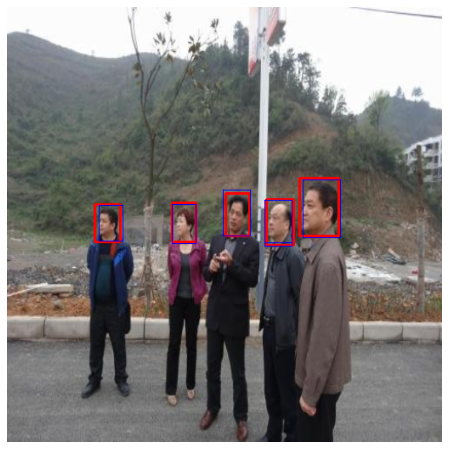

In [46]:
images,targets,image_id = next(valid_iter)
dev_images = [img.to(torch.device('cuda')) for img in images]
model.eval()
with torch.no_grad():
    outputs = model(dev_images)
outputs = {k: v.cpu() for k, v in outputs.items()}
show_predictions(images,outputs,targets)